In [1]:
# %env CONDA_PREFIX
# %env LD_LIBRARY_PATH=$CONDA_PREFIX/lib/python3.9/site-packages/tensorrt/:/lib/python3.9/site-packages/nvidia/cudnn/

env: LD_LIBRARY_PATH=$CONDA_PREFIX/lib/python3.9/site-packages/tensorrt/:/lib/python3.9/site-packages/nvidia/cudnn/


In [1]:
# %%bash
# echo $LD_LIBRARY_PATH
# export LD_LIBRARY_PATH=$CONDA_PREFIX/lib/python3.9/site-packages/tensorrt/:/lib/python3.9/site-packages/nvidia/cudnn/
# echo $LD_LIBRARY_PATH
# export XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda


/home/sylvia/anaconda3/lib/python3.9/site-packages/tensorrt/:/lib/python3.9/site-packages/nvidia/cudnn/


### RUN THESE COMMANDS IN THE TERMINAL BEFORE RUNNING THIS NOTEBOOK ON GNU/LINUX
Then call `code` from the terminal to load up VSCode. It will not work otherwise since VSCode does not load the environment startup scripts.
It will not work if you run them in the notebook, only in the terminal.

For tensorrt:

```export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/python3.9/site-packages/tensorrt/```

For cudnn:

```export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/python3.9/site-packages/nvidia/cudnn/lib/```

For devicelib:

```export XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda```

In [1]:
import os, warnings
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.python.client import device_lib

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    './car_or_truck_data/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    './car_or_truck_data/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

2023-02-20 02:33:56.204689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 5117 files belonging to 2 classes.


2023-02-20 02:33:57.542174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 02:33:57.544408: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 02:33:57.544564: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 02:33:57.544974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Found 5051 files belonging to 2 classes.


In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                  input_shape=[128, 128, 3]),
    layers.MaxPool2D(),

    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    # YOUR CODE HERE
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])

In [3]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [5]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
)

Epoch 1/50
80/80 [==============================] - 2s 23ms/step - loss: 0.1466 - binary_accuracy: 0.9414 - val_loss: 0.4481 - val_binary_accuracy: 0.8377
Epoch 2/50
80/80 [==============================] - 2s 23ms/step - loss: 0.1432 - binary_accuracy: 0.9427 - val_loss: 0.4442 - val_binary_accuracy: 0.8295
Epoch 3/50
80/80 [==============================] - 2s 23ms/step - loss: 0.1430 - binary_accuracy: 0.9437 - val_loss: 0.4601 - val_binary_accuracy: 0.8323
Epoch 4/50
80/80 [==============================] - 2s 23ms/step - loss: 0.1308 - binary_accuracy: 0.9492 - val_loss: 0.4721 - val_binary_accuracy: 0.8337
Epoch 5/50
80/80 [==============================] - 2s 23ms/step - loss: 0.1248 - binary_accuracy: 0.9527 - val_loss: 0.4840 - val_binary_accuracy: 0.8167
Epoch 6/50
80/80 [==============================] - 2s 23ms/step - loss: 0.1269 - binary_accuracy: 0.9560 - val_loss: 0.4827 - val_binary_accuracy: 0.8200
Epoch 7/50
80/80 [==============================] - 2s 23ms/step - los

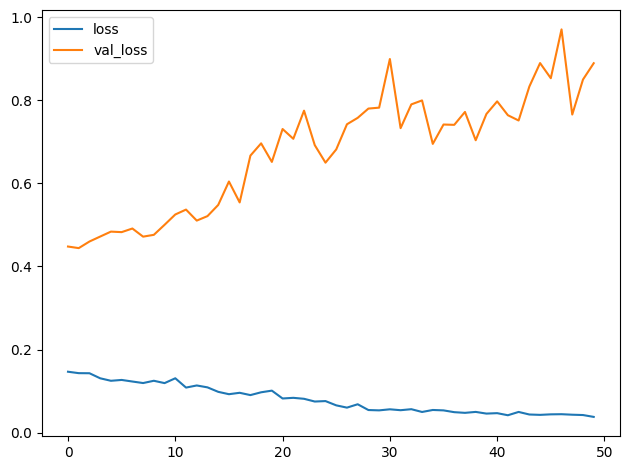

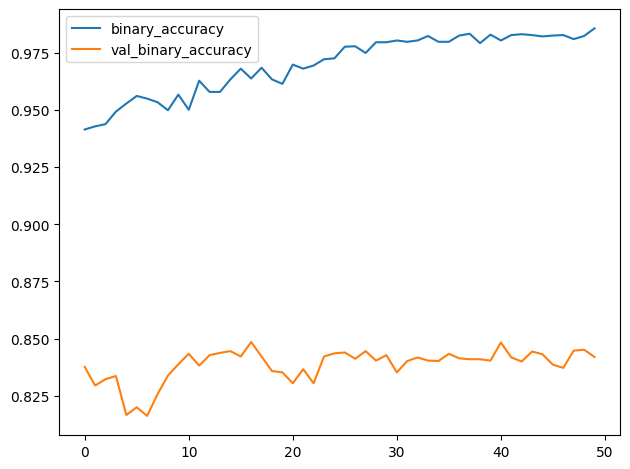

In [7]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [8]:
from tensorflow.python.client import device_lib
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
print(device_lib.list_local_devices())

GPU is available
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10063291395697030539
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22029533184
locality {
  bus_id: 1
  links {
  }
}
incarnation: 124428445474388889
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:09:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2023-02-20 02:41:54.235469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 02:41:54.235644: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 02:41:54.235752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 02:41:54.235906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 02:41:54.236017: I tensorflow/compiler/xla/stream_executo